# BLU05 - Learning Notebook - Part 2 of 3 - SARIMAX

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
from random import seed
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
seed(1)
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
import utils
from utils import load_airlines_series
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 4)

Let's get our airlines dataset. We've already become good friends after this much interaction :)

In [2]:
airlines = utils.load_airline_data()

Before going into the modelling, let's make the variance of our time series approximately stationary using `log`. 

As you learned in the previous notebook, to make the time series stationary we should also `diff` it to remove the trend. Here we're going to skip that step, because as you will see later the model can actually do that for us.

In [3]:
airlines_logged = np.log(airlines)

Now, like in any modelling problem, let's split the dataset into _train_ and _test_ to make sure we don't leak any information. Sometimes simply looking at the test set can give us intuition that we shouldn't have (it's like if we're studying for an exam knowing the solutions, we would be tempted to simply memorize the answers rather than actually learn). Remember that the goal of evaluating a model is to obtain a good estimation of its generalization error to never-before-seen data. For that, we need to pretend we don't know there is a test dataset, and use it only at the end when assessing the model.

Also, in timeseries dataset splits need to take into account the temporal nature of the data. Basically, this means that in a  simple train-test split we leave the first _X_ months for training and the last _Y_ months for testing. As we're working with monthly data, let's leave 2 years (24 values) for testing:

In [4]:
train = airlines_logged[:-24]
test = airlines_logged[-24:]

## 1. ARIMA 

[ARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html) is one of the most used models for predicting timeseries, and it stands for: 

- (AR) Auto Regressive 
- (I)  Integrated 
- (MA) Moving Average

There are also more sophisticated versions that we will get to later, but for now we'll use the [plain vanilla version](https://whatis.techtarget.com/definition/vanilla) to develop some intuitions.

### 1.1 Hyperparameters

The ARIMA model elegantly depends only on 3 parameters: 

> `ARIMA(p,d,q)`

Looking at the meaning behind  each parameter helps us to understand what this model is all about:

- `p`: the number of auto-regressive terms. These are the lags of variable we want to predict. Is the present point dependent on the previous one? On the previous two? Eight? If you're curious about this, take a look at this [wiki](https://en.wikipedia.org/wiki/Autoregressive_model) and [video](https://www.youtube.com/watch?v=5-2C4eO4cPQ) about the AR model, from where this `p` parameter originates from.



- `d`: the "integrated" part of the name means we take the `diff` between consecutive periods to make the timeseries stationary. We've already done this ahead of time (because we needed it for our ACF and PACF plots in Part 1), but you can also leave it as a hyper parameter and tune it later. If you're curious about this, take a look at this [wiki](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and [video](https://www.youtube.com/watch?v=3UmyHed0iYE) (suggestion: if you're going to watch the video, watch first the AR and MA ones).



- `q`: the number of moving average terms. The logic here is similar to the one we used for `p`, but instead of predicting a variable based on its lagged values, we are predicting errors with lagged errors (i.e., the MA terms are lagged forecast errors). In this model, what predicts `x(t)` is `e(t-1)`, `e(t-2)`, ..., where `e(i)` is the difference between the moving average at the ith instant and the actual value. If you're curious about this, take a look at this [wiki](https://en.wikipedia.org/wiki/Moving-average_model) and [video](https://www.youtube.com/watch?v=voryLhxiPzE) about the MA model, from where this `q` parameter originates from.

These hyperparameters will define the architecture (skeleton) of your model. The defined model will then be fitted to your dataset via maximum likelihood estimation. For a more thorough explanation of the math behind ARIMA make sure to check this [article](https://people.duke.edu/~rnau/411arim.htm). You can also take a look at this nice and short discussion on [AR vs MA](https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-ar-and-ma-time-series-models/2131/3).

In summary, the ARIMA model was created when a bunch of hungry statisticians got stuck in a cave during a massive blizzard and decided to try out boiling the AR and MA models together, while adding some Integrated seasoning in the process.

### 1.2 Hyperparameter Selection

And how do we choose them? The artisanal way to decide `p` and `q` is to use the table below.

|      |         AR(p)        |         MA(q)        | ARMA(p,q) |
|:----:|:--------------------:|:--------------------:|:---------:|
|  ACF |       Tails off      | Cuts off after lag q | Tails off |
| PACF | Cuts off after lag p |       Tails off      | Tails off |

What is "cut off" and "tail off" you ask? "Cut off" means there is an abrupt decrease to 0 after a certain lag. "Tail off" means the autocorrelation is slowly decreasing over time. This [stack exchange question](https://stats.stackexchange.com/questions/241914/terms-cut-off-and-tail-off-about-acf-pacf-functions) has an interesting discussion about it.

Let's calculate the PACF and ACF plots for our train dataset. Note that we added the `.diff()` because these plots require a stationary time series. The `.dropna()`, on the other hand, handles the first value being `nan` caused by the `.diff()` (the PACF and ACF functions can't handle those).

Remember that the first bar corresponds to lag 0, so it's always equal to 1.

**Side-note**: while `.dropna()` is enough to handle `nan` values right in the beginning or end of the timeseries (like the ones we get when using `.diff()`), you should not do this to a dataset with missing data in the middle. If you feel like a hardcore timeseries fan, take a look at the supplementary notebook *Handling nan in ACF like a pro* (where you can find a light explanation on this issue) after you finish the BLU.

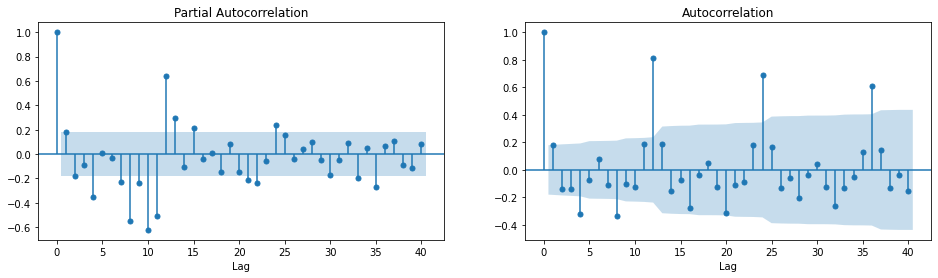

In [5]:
fig, ax = plt.subplots(1,2)
plot_pacf(train.diff().dropna(), alpha=.05, lags=40, ax=ax[0], method='ols') 
plot_acf(train.diff().dropna(), alpha=.05, lags=40, ax=ax[1])
ax[0].set_xlabel('Lag')
ax[1].set_xlabel('Lag')
plt.show()

Our case doesn't seem like either a pure _AR_ nor pure _MA_ process because there's no clear tail off nor cut off. In this situation, the autocorrelation plots can't tell us how to choose the parameters. Get used to it, because this will happen in most cases.

If you search through the internet you may find several rules of thumb to try and choose the parameters in these cases, but several will be contradictory. At the end of the day the best approach is to use an automatic method, just like we do hyperparameter tuning in machine learning models. So, let's use some parameters that have been previously found by an automatic method. Don't worry, you will learn this soon ;)

### 1.3 Modelling

We will start by using our previously found parameters. Note that the `d=1` (= lag1 is relevant) may be explained by the fact that our `train` dataset isn't `diff`'ed. If we had used the diffed one (removing a possible trend on the data), potentially we would get the same parameters but with `d=0`.

In [6]:
# sets up a model using previously found parameters via an automatic method
arima = SARIMAX(train, order=(2, 1, 1),trend='c')

# trains the model
arima_results = arima.fit()

# our model prediction, with the log transform undone using exp (exponential)
# the [1:] will be explained later on
arima_predictions = np.exp(arima_results.predict())[1:]

/home/rasilva/.virtualenvs/blu05-batch5v2/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [7]:
print('Can this possibly return a... %s  OH MY GOD IT DID THAT IS SO AWESOME!!' % type(arima_predictions))

Can this possibly return a... <class 'pandas.core.series.Series'>  OH MY GOD IT DID THAT IS SO AWESOME!!


A few of things to note about the API (the interface which allows us to implement so easily the ARIMA model):
1. We passed the data straight to the model (unlike in `sklearn`) .
3. We passed the order `(p, d, q)` as `(2, 1, 1)`.
4. We called `fit` without any parameters (which is also different from `sklearn`).
5. The model isn't fit in place (i.e., we have to store the fitted model in a separate variable), we have to grab the results with a `arima_results`.
6. The first value of the prediction is 0, since we don't have the lags needed to forecast it. We did `[1:]` to remove this value from our prediction.

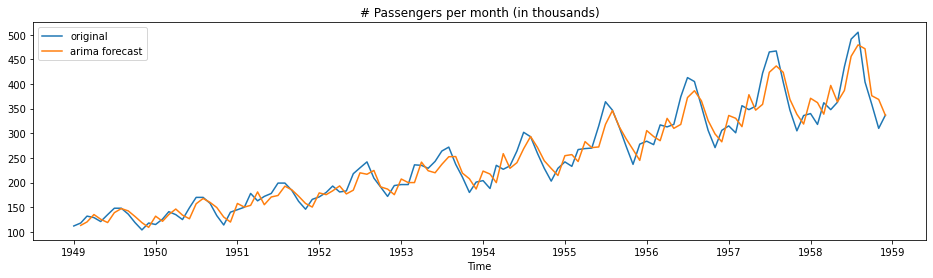

In [8]:
plt.plot(np.exp(train), label='original')
plt.plot(arima_predictions, label='arima forecast')
plt.xlabel('Time')
plt.title('# Passengers per month (in thousands)')
plt.legend()
plt.show()

Hmm not too bad, but not perfect either. Also, there seems to be some seasonality in the data that we're not taking into account with our current model... See how the forecast seems to be always late relative to the seasonal variation? I guess we'll have to use the SARIMAX!

## 2. SARIMAX

This is the SARIMAX. What does that stand for? 

![](https://i.imgflip.com/2ab2xu.jpg)

The **Autoregressive Integrated Moving Average** part we already know _(well... kind of anyway)_.

Now, what about the new bits?

- **`Seasonal`**: as the name suggests, this model can actually deal with seasonality. Coool.... 
- **`With Exogenous regressors`** roughly means we can add external information to our model. For instance, if we were to predict ice cream sales, it would surely be useful to complement past sales values with the temperature timeseries. This will be explained in more detail in the next learning notebook.

In terms of parameters, we have  
- `p`, `d` and `q`: these are the same as before.
- `P`, `D` and `Q`: these are analogous to the previous ones, but refer to the seasonal part of the timeseries.
- `S`: an integer giving the periodicity (number of periods in season). If we have daily data and suspect we may have weekly trends, we may want `S` to be 7. If the data is monthly and we think the time of the year may count, maybe try `S` at 12.

If you're ever curious about these parameters, take this [documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) to understand them better.

Time for a break. We can imagine that by now you must feel overloaded with all these models and parameters. Keep calm! This process takes time and no one expects you to become an expert after completing this specialization. What is expected is that you get in touch with a bunch of terminology and concepts, so that you get an overall idea of timeseries.

![](images/timeseries_stress.jpg)

Now, going back to timeseries. We just talked about a bunch of parameters... But how do we choose them? Well, `S` is quite intuitive. Looking at the ACF we can see a strong correlation with lag 12, 24, 36, etc., thus indicating yearly seasonality! Hence `S = 12`. Regarding `P`, `D` and `Q` it's even less intuitive than our previous ones, so we'll just use some pre-defined values. Remember that at the end of the day we will use an automatic method to choose this, just like we do with machine learning models.

In [9]:
# sets up the SARIMAX model
sarimax = SARIMAX(train, trend='c',        
                         order=(2, 0, 0),              # <-- keeping same parameters as before
                         seasonal_order=(0, 1, 1, 12)) # <-- we'll get into how we found these hyper parameters later

# trains the SARIMAX model
sarimax_results = sarimax.fit(maxiter=1000)

# predictions
sarimax_predictions = np.exp(sarimax_results.predict())[24:] # grab the prediction from our model and undo the log transform using exp

Done! Seriously, check this out: 

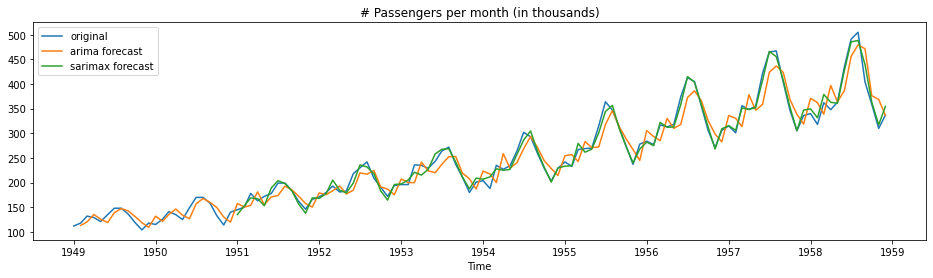

In [10]:
plt.plot(np.exp(train), label='original')
plt.plot(arima_predictions, label='arima forecast')
plt.plot(sarimax_predictions, label='sarimax forecast')
plt.xlabel('Time')
plt.title('# Passengers per month (in thousands)')
plt.legend()
plt.show()

From the plot, SARIMAX clearly looks better, but how can we quantify this?

### 2.1 In-sample evaluation (or training performance)

The standard metric for timeseries classical models is the AIC (Akaike information criterion), a metric that measures how well the model fits the data while taking into account model complexity. If the model is very complex, the expectation on how well it must fit the data will also go up. It is therefore useful for comparing models. 

If you (for some weird reason) feel compelled to calculate it by hand, [this post](https://stats.stackexchange.com/questions/87345/calculating-aic-by-hand-in-r?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa) explains how to do so. Then again, it's sunny and beautiful outside, and _statsmodel_ has got your back.

In [11]:
arima_results

In [12]:
arima_results.aic

-224.49759443496853

In [13]:
sarimax_results.aic

-393.53618189646556

Smaller is better, so the more negative the better. It's then clear that our SARIMAX is significantly better than our ARIMA model, just like the plot hinted.

You may already be thinking that using AIC we can compare different models, perhaps that's how we got to those magical hyperparameters...?

Well SARIMAX seems to be significantly better than the ARIMA! But you're probably thinking: we're just looking at how well each of the models fits the train dataset, not how well it generalizes. And you would be correct! Let's look into doing actual forecasts with our models.

## 3. Forecasting

Previously we used `predict()` to get in-sample predictions (from the training subset). Now we need to use `get_forecast()` to get out-of-samples (from the independent test subset). Also note that in timeseries nomenclature, it's common to call _predictions_ to in-sample predictions and _forecasts_ for out-of-sample predictions.

**PS:** on the `predict()` method there is a dynamic parameter which is supposed to simulate a forecast. **Do not use this**. This makes an inference that only uses the labels until a certain point, and from then on makes a multi-step forecast. The problem is that this model has previously been fitted with the whole dataset. This means you are training the model on the whole dataset, and then forecasting an interval within this dataset. This is a clear case of data leakage and there is no situation in which you should use this, always go for the method below.

### 3.1 Individual forecasts (one-step & multi-step)

The `predict()` we used is only for in-sample predictions. For inference we use `get_forecast()`. An important distinction in timeseries forecasting is between one-step forecasting and multi-step forecasting. But it's actually quite simple, the first means we're just predicting the next step, the second means we're predicting multiple steps (where "steps" refers to the following timesteps). Using the `get_forecast()` method we can specify how many steps we want.

In [14]:
arima_forecast = arima_results.get_forecast(24)

In [15]:
sarimax_forecast = sarimax_results.get_forecast(24)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


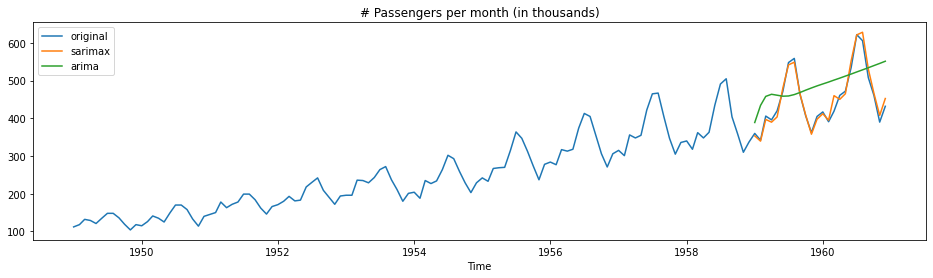

In [16]:
plt.plot(airlines, label='original')
plt.plot(np.exp(sarimax_forecast.predicted_mean), label='sarimax')
plt.plot(np.exp(arima_forecast.predicted_mean), label='arima')
plt.xlabel('Time')
plt.title('# Passengers per month (in thousands)')
plt.legend()
plt.show()

Great! But these are just the forecasts that would have been made at time `t=1959-11-30`, which is the last sample in our train set. What if we want to validate how well our model would have performed during the entire test set? As in, performing a new forecast on each month.

### 3.2 Ongoing Forecasts

In 3.1, we put in practice some one-off forecasting. But in the real world, most often what is needed are operational systems which issue forecasts regularly. And in such cases, be it one-step or multi-step, we have to remind ourselves of this: as time goes on, new data becomes available. And ingesting fresh new data may be quite useful for model fine-tuning and grasping new dynamics on the data (be aware that this is not always the case).

As an illustrative example, if on the `1960-02-01` we want to make a forecast (one- or multi-step) we would want to use the data up to `1960-01-31`. However, in `1960-03-01` it would be of interest to somehow integrate the new data record in an attempt to produce better forecasts.

How can we do this? There are two main options:

- **Static Model:** This means we maintain the same model, meaning the same hyperparameters (p,d,q,P,D,Q,S) and the same parameters (the ones estimated during the train set fitting). We simply change the starting point of the forecast to the new sample of data we feed the model.
- **Dynamic Model:** This means we're going to make use of the new sample of the data to actually change our model. We can do this in three different ways:
    - **Refit:** Here we're going to maintain the model hyperparameters, but we'll retrain the model using the new data.
    - **Remake:** Here we're going to remake the model, meaning we will find the hyperparameters again and make a new fitting.
    
Having so many options may seem daunting, but if you think about it it's quite simple and seamlessly translates to how you maintain machine learning models. From static model, to refitting, to remaking, we're going from a more conservative to a more reactive approach to model maintenance. Being more reactive means giving more weight to new data, but also having more work because you will change your model and that may require some validations to make sure everything's working as it should. In practice, what should be done depends on the specifics of the project. For monthly forecasts like this, you probably don't want to maintain a static model, you're quite confident you can update it. But you probably also don't want to remake the model every month. If you're interested in learning more about this check [statmodels documentation on it](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html).

Let's see how we can do all these approaches in _statsmodels_. We will only look at multiple forecasts for the one-step case, which is equivalent to the multi-step with a step equal to 1.

In [17]:
# This may take a minute or two to run. Go grab a coffee ;) 

# our multi-step forecasts
sarimax_results_static = sarimax_results
sarimax_results_refit = sarimax_results

# variables where we will store all our forecasts
sarimax_forecast_one_step_static = []
sarimax_forecast_one_step_refit = []

for i in np.arange(0,24):
    # Static Forecast
    next_step_forecast = sarimax_results_static.get_forecast().predicted_mean[0] # stores one step ahead static forecast
    sarimax_forecast_one_step_static.append(next_step_forecast) # stores the forecast
    sarimax_results_static = sarimax_results_static.append(test[i:i+1]) # adds the corresponding observation to feed the next one step forecast
    
    # Refit Forecast
    next_step_forecast = sarimax_results_refit.get_forecast().predicted_mean[0]
    sarimax_forecast_one_step_refit.append(next_step_forecast)
    sarimax_results_refit = sarimax_results_refit.append(test[i:i+1], refit=True,
                                                         fit_kwargs={'method':'nm', 'maxiter':1000,'disp':False})

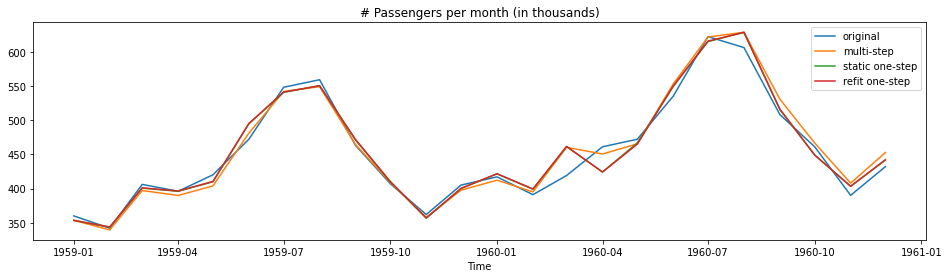

In [18]:
plt.plot(airlines[-24:], label='original') # Removed part of the observations to highlight model differences
plt.plot(np.exp(sarimax_forecast.predicted_mean), label='multi-step')
plt.plot(test.index,np.exp(sarimax_forecast_one_step_static), label='static one-step')
plt.plot(test.index,np.exp(sarimax_forecast_one_step_refit), label='refit one-step')
plt.xlabel('Time')
plt.title('# Passengers per month (in thousands)')
plt.legend()
plt.show()

All of them seem quite similar! It seems we need to start quantifying the performance to distinguish between similar models.

## 4. Out-of-Sample Evaluation

Even though for validation and hyperparameter optimisation it's common to use AIC, the truth is that in real world projects you (and your customers) will care about more common metrics such as the mean average error (MAE) or mean squared error (MSE), since these are much more interpretable and can be calculated without depending on the models (as we were doing with the `arima_results.aic`).

**Moment of ZEN**: in case you're super excited about forecasting metrics (who wouldn't!), you might want to take a look at these complementary reading references: [Forecasting KPIs](https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d), [Basics of Forecast Accuracy](https://medium.com/analytics-vidhya/basics-of-forecast-accuracy-db704b0b001b) and [Error Metrics: How to Evaluate Your Forecasts](https://www.jedox.com/en/blog/error-metrics-how-to-evaluate-forecasts/).

Let's then calculate the MAE for our three forecasts:

In [19]:
mean_absolute_error(np.exp(sarimax_forecast.predicted_mean),np.exp(test))

10.616247570447404

In [20]:
mean_absolute_error(np.exp(sarimax_forecast_one_step_static),np.exp(test))

11.072142589941024

In [21]:
mean_absolute_error(np.exp(sarimax_forecast_one_step_refit),np.exp(test))

11.282900890545195

The results are quite surprising: it seems that the multi-step is the best forecast! This means that a model with no knowledge of the following 24 months performed better than a model which always had information regarding the previous month (even if the model is refit!!).

Let's try to understand a bit better why this happens (while being aware that these sorts of conclusions are very context dependent).

### 4.1 Error Analysis

To understand the performance of each model over time, let's calculate the rolling MAE (trying out the very useful `.expanding()` function).

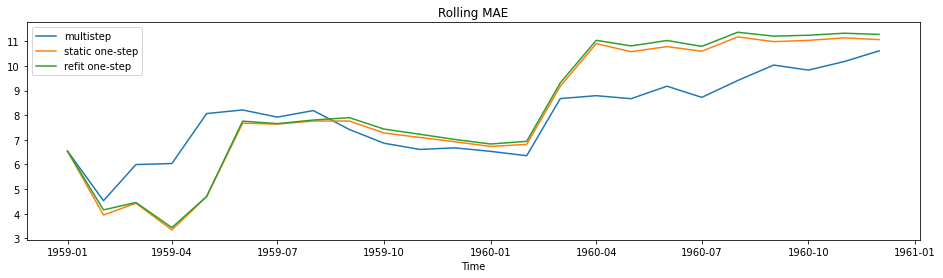

In [22]:
plt.plot(test.index, np.abs(np.exp(sarimax_forecast.predicted_mean)-airlines[120:]).expanding().mean(), label='multistep')
plt.plot(test.index,np.abs(np.exp(sarimax_forecast_one_step_static)-airlines[120:]).expanding().mean(), label='static one-step')
plt.plot(test.index,np.abs(np.exp(sarimax_forecast_one_step_refit)-airlines[120:]).expanding().mean(), label='refit one-step')
plt.title('Rolling MAE')
plt.xlabel('Time')
plt.legend()
plt.show()

Well, this is interesting. It seems the multi-step model was performing worse (bigger MAE) during most of the time, but in 1960 after March the patterns changes. If we check on the time series plot above, we can see that it's exactly in March of 1960 that all models start making a significant error on the prediction. All the models predicted an increase, but the actual values actually decreased, and it so happened that the multi-step was a bit closer to the real values compared to the one-step ones. At the end of the day when there are distribution changes, there will always be some randomness involved.

Remember that we mentioned the choice of hyperparameters for the  SARIMAX? Proceed to the next notebook to find out more about this.